# Set up the big wind farm

In [1]:
# Load the amrwind-frontend module
amrwindfedir = '/projects/wind_uq/lcheung/amrwind-frontend'  # Location of amrwind-frontend 
import sys, os
sys.path.insert(1, amrwindfedir)

# Load the libraries
import amrwind_frontend  as amrwind
import matplotlib.pyplot as plt
import numpy             as np
import math
import postproamrwindabl as postpro

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

In [2]:
with open(amrwindfedir+"/turbines/IEA15MW.yaml")as f: print(f.read())

turbines:
  IEA15MW_Joukowski:     # This is an arbitrary, unique name
    turbinetype_name:    "IEA15MW_Joukowsky"
    turbinetype_comment: "Dummy layout"   # arbitrary
    Actuator_type:                JoukowskyDisk
    Actuator_rotor_diameter:      240
    Actuator_hub_height:          150     # Double-check
    Actuator_output_frequency:    10                   
    # --------------------
    Actuator_diameters_to_sample: 2.5     # How far upstream to sample inflow wind
    #Actuator_epsilon:             [5.0]   # Epsilon in Z (might need to play with this guy)
    Actuator_num_points_r:        40      # number of radial (might need to play with this guy)
    Actuator_num_points_t:        5       # number of pts in theta (might need to play with this guy)
    #Actuator_vortex_core_size:    24.0    # might need to play with this
    # --------------------
    # These will come from
    # https://github.com/IEAWindTask37/IEA-15-240-RWT/blob/master/performance/performance_ccblade.dat


In [3]:
# Start the AMR-Wind case
case = amrwind.MyApp.init_nogui()

In [4]:
# Load the starting point
inputfile='../precursorBig_51x51_tall.3/Neutral_9mps_precursorBig_tall_refined4.inp'
case.loadAMRWindInput(inputfile)
outputfile    = 'Neutral_9mps_BigFarm_tall_allturbs.inp'
precursorfile = 'Neutral_9mps_BigFarm_tall_noturbs.inp'

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()


## Set up the restart from boundary planes

In [5]:
WS     = 9             # Wind speed, m/s
WDir   = 200           # Wind direction, degrees

case.setAMRWindInput('useWSDir', True)
case.setAMRWindInput('ABL_windspeed', WS, forcechange=True)
case.setAMRWindInput('ABL_winddir',   WDir, forcechange=True)
case.ABL_calculateWindVector()

In [6]:
# Set the restart point
case.setAMRWindInput('restart_file','chk80000')

In [7]:
# Set the boundary conditions
case.setAMRWindInput('is_periodicx', False)
case.setAMRWindInput('is_periodicy', False)
case.setAMRWindInput('is_periodicz', False)

# Set the xlo boundary conditions
case.setAMRWindInput('xlo.type',      'mass_inflow')
case.setAMRWindInput('xlo.density',     1.0)
case.setAMRWindInput('xlo.temperature', 0.0)
# Set the ylo boundary conditions
case.setAMRWindInput('ylo.type',      'mass_inflow')
case.setAMRWindInput('ylo.density',     1.0)
case.setAMRWindInput('ylo.temperature', 0.0)

# Set the exit boundary conditions
case.setAMRWindInput('xhi.type', 'pressure_outflow')
case.setAMRWindInput('yhi.type', 'pressure_outflow')

case.extradictparams['xlo.tke'] = 0.0 # FIX THIS LATER
case.extradictparams['ylo.tke'] = 0.0 # FIX THIS LATER

In [8]:
# Set the boundary plane mode
case.setAMRWindInput('ABL.bndry_io_mode', '1')

In [9]:
case.ABLpostpro_loadnetcdffile('../precursorBig_51x51_tall.3/post_processing/abl_statistics70000.nc')

Loading ../precursorBig_51x51_tall.3/post_processing/abl_statistics70000.nc
Time range: 17500.250000 to 23199.500000
Done.


In [10]:
#case.ABLpostpro_getscalarslist()
t, abl_forcing_x = postpro.extractScalarTimeHistory(case.abl_stats, 'abl_forcing_x')
t, abl_forcing_y = postpro.extractScalarTimeHistory(case.abl_stats, 'abl_forcing_y')

In [11]:
# Set the body force
case.setAMRWindInput('BodyForce', True)
case.setAMRWindInput('BodyForce.magnitude', [np.mean(abl_forcing_x), np.mean(abl_forcing_y), 0.0])

In [12]:
# Unset the ABL forcing
case.setAMRWindInput('ABLForcing', False)
case.setAMRWindInput('ABLMeanBoussinesq', True)

## Set up wind farm turbines

In [13]:
# Define some properties
rotorD = 240           # Rotor diameter

# Farm properties
farm_rotate      = -20                          # Number of degrees to rotate turbine rows (relative to x-axis)

# ==== 50 turbine staggered arrangement ====
farm_title       = 'IEA 15MW, 50 turbine staggered arrangement'
# Turbine spacing
turb_LatSpacing  = 4   # lateral spacing, diameters
turb_LongSpacing = 5   # longitudinal spacing, diameters
# Define the rows
farmrowdict = [{'Nturb':6, 'rowoffset':0},
               {'Nturb':5, 'rowoffset':2},
               {'Nturb':6, 'rowoffset':0},
               {'Nturb':5, 'rowoffset':2},
               {'Nturb':6, 'rowoffset':0},
               {'Nturb':5, 'rowoffset':2},
               {'Nturb':6, 'rowoffset':0},
               {'Nturb':5, 'rowoffset':2},
               {'Nturb':6, 'rowoffset':0},
              ]

# Set the initial yaw for each turbine
turbineyaw = 200.0

turboffset=[0,0]

In [14]:
# Rotates a point pt about origin orig   
# Here theta is measured w.r.t. the x-axis
def rotatepoint(pt, orig, theta):
    dx = pt[0]-orig[0]
    dy = pt[1]-orig[1]
    p2=[0.0, 0.0]
    p2[0] = dx*math.cos(theta) - dy*math.sin(theta) + orig[0]
    p2[1] = dx*math.sin(theta) + dy*math.cos(theta) + orig[1]
    return p2

In [15]:
# Build the wind farm turbine positions
farmturb_xy = []
for irow, row in enumerate(farmrowdict):
    turb_y = irow*turb_LongSpacing*rotorD
    for iturb in range(row['Nturb']):
        turb_x = iturb*turb_LatSpacing*rotorD + row['rowoffset']*rotorD
        farmturb_xy.append([turb_x, turb_y])
farmturb_xy = np.array(farmturb_xy)

print("Total turbines = "+repr(len(farmturb_xy)))

Total turbines = 50


In [16]:
# Recenter the farm to be at the origin
farmturb_orig = np.mean(farmturb_xy, axis=0)
farmturb_xy = np.array([x-farmturb_orig for x in farmturb_xy])
farmturb_xy = np.array([rotatepoint(pt, [0.0, 0.0], farm_rotate*np.pi/180.0) for pt in farmturb_xy])

farmturb_xy = np.array([np.array(xy)+np.array(turboffset) for xy in farmturb_xy])

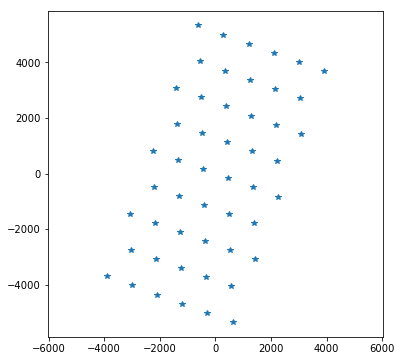

In [17]:
# Double check plot
plt.figure(figsize=(6,6))
plt.plot(farmturb_xy[:,0], farmturb_xy[:,1], '*')
plt.axis('equal');
#plt.xlim([-5000,5000])
#plt.ylim([-5000, 5000])

In [18]:
# Build the CSV input file of turbine layouts for amrwind-frontend
turbinescsv="""
# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
"""
rowformat="T%02i, %f, %f, IEA15MW_Joukowsky, %.2f, ,\n"
for iturb, xy in enumerate(farmturb_xy):
    turbinescsv += rowformat%(iturb, xy[0], xy[1], turbineyaw)
case.setAMRWindInput('turbines_csvtextbox',  turbinescsv)
print(case.getAMRWindInput('turbines_csvtextbox'))


# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
T00, -3896.958978, -3689.676236, IEA15MW_Joukowsky, 200.00, ,
T01, -2994.854062, -4018.015573, IEA15MW_Joukowsky, 200.00, ,
T02, -2092.749146, -4346.354911, IEA15MW_Joukowsky, 200.00, ,
T03, -1190.644230, -4674.694249, IEA15MW_Joukowsky, 200.00, ,
T04, -288.539314, -5003.033586, IEA15MW_Joukowsky, 200.00, ,
T05, 613.565602, -5331.372924, IEA15MW_Joukowsky, 200.00, ,
T06, -3035.482348, -2726.214760, IEA15MW_Joukowsky, 200.00, ,
T07, -2133.377432, -3054.554097, IEA15MW_Joukowsky, 200.00, ,
T08, -1231.272516, -3382.893435, IEA15MW_Joukowsky, 200.00, ,
T09, -329.167600, -3711.232772, IEA15MW_Joukowsky, 200.00, ,
T10, 572.937316, -4039.572110, IEA15MW_Joukowsky, 200.00, ,
T11, -3076.110634, -1434.413946, IEA15MW_Joukowsky, 200.00, ,
T12, -2174.005718, -1762.753283, IEA15MW_Joukowsky, 200.00, ,
T13, -1271.900802, -2091.092621, IEA15MW_Joukowsky, 200.00, ,
T14, -369.795886, -2419.431959, IEA15MW_Joukowsky, 200.00

In [19]:
case.setAMRWindInput('turbines_createnewdomain', False)
case.setAMRWindInput('turbines_deleteprev', True)

case.turbines_createAllTurbines()

# Print out existing list of turbines, just to confirm that the turbines got made
print(case.listboxpopupwindict['listboxactuator'].getitemlist())

['T00', 'T01', 'T02', 'T03', 'T04', 'T05', 'T06', 'T07', 'T08', 'T09', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27', 'T28', 'T29', 'T30', 'T31', 'T32', 'T33', 'T34', 'T35', 'T36', 'T37', 'T38', 'T39', 'T40', 'T41', 'T42', 'T43', 'T44', 'T45', 'T46', 'T47', 'T48', 'T49']


In [20]:
# Set some globals for the actuator disk
eps         = 5.0
vortex_core = 24.0

## make sure to add Actuator to incflo.physics
#newphysics=case.getAMRWindInput('incflo.physics') + ['Actuator']
#case.setAMRWindInput('incflo.physics', newphysics)
case.setAMRWindInput('Actuator_default_type', ['JoukowskyDisk'])
case.setAMRWindInput('Actuator_JoukowskyDisk_epsilon',       [eps], forcechange=True)  # You can change this
case.setAMRWindInput('Actuator_JoukowskyDisk_vortex_core_size', vortex_core, forcechange=True)  # You can change this

## Set up refinement zones

In [21]:
# Get box dimensions
prob_lo = case.getAMRWindInput('geometry.prob_lo')
prob_hi = case.getAMRWindInput('geometry.prob_hi')
Lx = prob_hi[0] - prob_lo[0]
Ly = prob_hi[1] - prob_lo[1]
deltarefine = 1000

In [22]:
### ADD REFINEMENT WINDOWS

## -- level 0 --
# Get the default dictionary for refinement window
refinewin = case.get_default_taggingdict()
# Edit the parameters of the refinement window
refinewin['tagging_name']         = 'box40'
refinewin['tagging_shapes']       = 'box40'
refinewin['tagging_type']         = 'GeometryRefinement'
refinewin['tagging_level']        = 0
refinewin['tagging_geom_type']    = 'box'
refinewin['tagging_geom_origin']  = [-0.5*Lx + deltarefine, -0.5*Ly + deltarefine, 0]
refinewin['tagging_geom_xaxis']   = [Lx - 2*deltarefine, 0, 0]
refinewin['tagging_geom_yaxis']   = [0, Ly - 2*deltarefine, 0]
refinewin['tagging_geom_zaxis']   = [0, 0, 2000]
# Add refinement zone to simulation.
case.add_tagging(refinewin, deleteprevious=True)

## -- level 1 --
# Get the default dictionary for refinement window
refinewin = case.get_default_taggingdict()
# Edit the parameters of the refinement window
refinewin['tagging_name']         = 'box20'
refinewin['tagging_shapes']       = 'box20'
refinewin['tagging_type']         = 'GeometryRefinement'
refinewin['tagging_level']        = 1
refinewin['tagging_geom_type']    = 'box'
refinewin['tagging_geom_origin']  = [-0.5*Lx + deltarefine, -0.5*Ly + deltarefine, 0]
refinewin['tagging_geom_xaxis']   = [Lx - 2*deltarefine, 0, 0]
refinewin['tagging_geom_yaxis']   = [0, Ly - 2*deltarefine, 0]
refinewin['tagging_geom_zaxis']   = [0, 0, 1500]
# Add refinement zone to simulation.
case.add_tagging(refinewin, deleteprevious=False)

## -- level 2 --
# Get the default dictionary for refinement window
refinewin = case.get_default_taggingdict()
# Edit the parameters of the refinement window
refinewin['tagging_name']         = 'box10'
refinewin['tagging_shapes']       = 'box10'
refinewin['tagging_type']         = 'GeometryRefinement'
refinewin['tagging_level']        = 2
refinewin['tagging_geom_type']    = 'box'
refinewin['tagging_geom_origin']  = [-0.5*Lx + deltarefine, -0.5*Ly + deltarefine, 0]
refinewin['tagging_geom_xaxis']   = [Lx - 2*deltarefine, 0, 0]
refinewin['tagging_geom_yaxis']   = [0, Ly - 2*deltarefine, 0]
refinewin['tagging_geom_zaxis']   = [0, 0, 1100]
# Add refinement zone to simulation.
case.add_tagging(refinewin, deleteprevious=False)

In [23]:
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
3,     1.25,     1.25,       1.25, 0.525, 0.525,
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv)
case.setAMRWindInput('refine_deleteprev', False)

In [24]:
case.refine_createAllZones()
# Print out existing list of zones
print(case.listboxpopupwindict['listboxtagging'].getitemlist())

['box40', 'box20', 'box10', 'T00_level_3_zone', 'T01_level_3_zone', 'T02_level_3_zone', 'T03_level_3_zone', 'T04_level_3_zone', 'T05_level_3_zone', 'T06_level_3_zone', 'T07_level_3_zone', 'T08_level_3_zone', 'T09_level_3_zone', 'T10_level_3_zone', 'T11_level_3_zone', 'T12_level_3_zone', 'T13_level_3_zone', 'T14_level_3_zone', 'T15_level_3_zone', 'T16_level_3_zone', 'T17_level_3_zone', 'T18_level_3_zone', 'T19_level_3_zone', 'T20_level_3_zone', 'T21_level_3_zone', 'T22_level_3_zone', 'T23_level_3_zone', 'T24_level_3_zone', 'T25_level_3_zone', 'T26_level_3_zone', 'T27_level_3_zone', 'T28_level_3_zone', 'T29_level_3_zone', 'T30_level_3_zone', 'T31_level_3_zone', 'T32_level_3_zone', 'T33_level_3_zone', 'T34_level_3_zone', 'T35_level_3_zone', 'T36_level_3_zone', 'T37_level_3_zone', 'T38_level_3_zone', 'T39_level_3_zone', 'T40_level_3_zone', 'T41_level_3_zone', 'T42_level_3_zone', 'T43_level_3_zone', 'T44_level_3_zone', 'T45_level_3_zone', 'T46_level_3_zone', 'T47_level_3_zone', 'T48_level_3

Plotting turbines


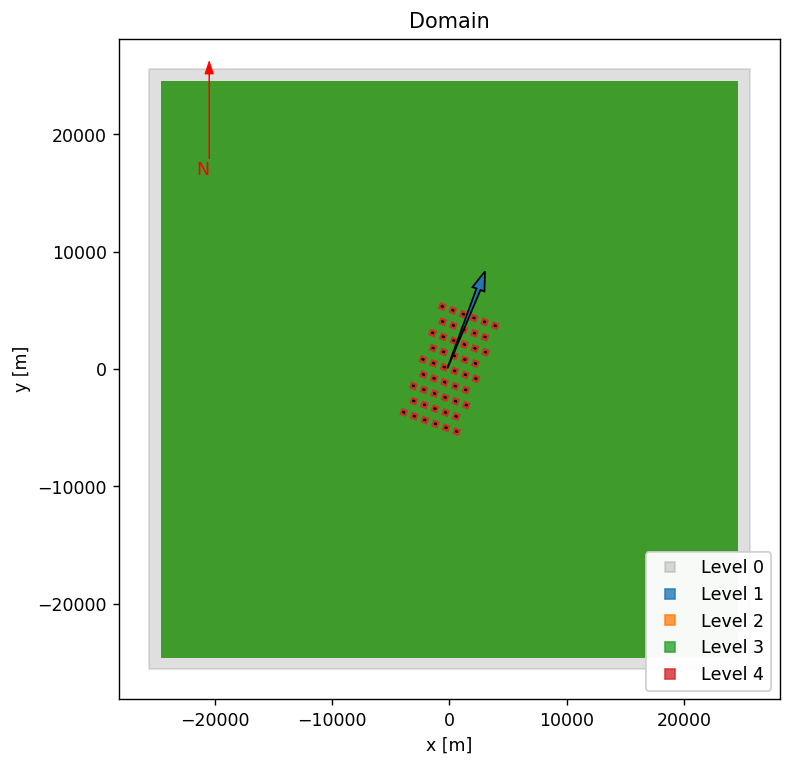

In [25]:
# Plot the domain
fig, ax = plt.subplots(figsize=(7,7), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = [] #['p_hub']
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY' 
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.plotDomain(ax=ax)

Plotting turbines


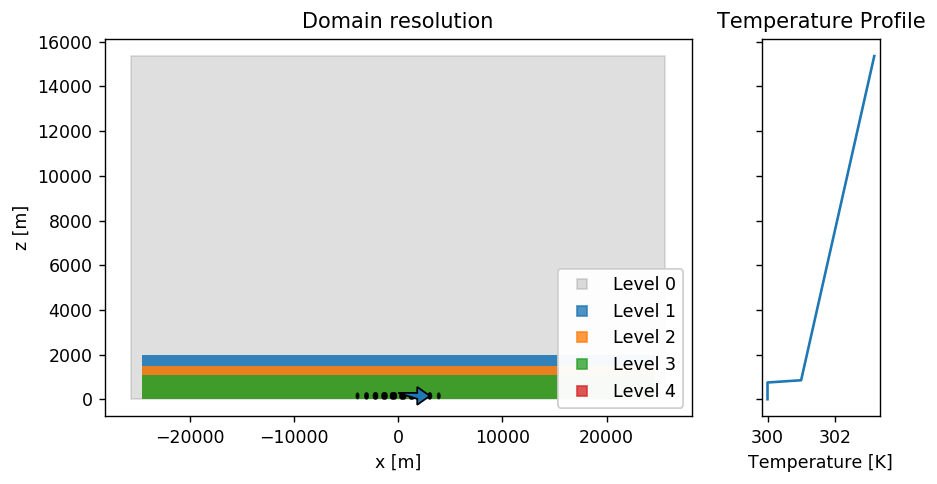

In [26]:
fig, axs = plt.subplots(1,2, figsize=(8,4), facecolor='w', dpi=125, sharey=True, 
                        gridspec_kw={'width_ratios': [5, 1]})

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = [] #['p_hub']
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XZ' 
case.popup_storteddata['plotdomain']['plot_refineboxes']     = ['box40', 'box20', 'box10'] 
case.plotDomain(ax=axs[0])
axs[0].set_title('Domain resolution')
#axs[0].set_xlim([-0.5*Lx, 0.5*Lx])
axs[0].set_xlim([-30000, 30000])
axs[0].axis('tight')

case.plotGenericProfile('ABL.temperature_values', 'ABL.temperature_heights', ax=axs[1])
#axs[1].set_ylim([0,16000])
axs[1].set_xlabel('Temperature [K]')
axs[1].set_title('Temperature Profile')

## Add sampling and averaging 

In [27]:
case.setAMRWindInput('incflo.post_processing',    ['sampling', 'averaging'])
case.setAMRWindInput('sampling.output_frequency', 1200)
case.setAMRWindInput('sampling.fields',           ['velocity', 'temperature', 'velocity_mean'])

In [28]:
# Set the averaging properties
case.setAMRWindInput('averaging.averaging_window',     600)
case.setAMRWindInput('averaging.averaging_start_time', 20300)

In [29]:
case.extradictparams['averaging.labels'] = 'means'
case.extradictparams['averaging.means.fields'] = 'velocity'
case.extradictparams['averaging.means.averaging_type'] = 'ReAveraging'

In [30]:
# Set up the extra sampling
samplingcsv="""
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name, type, upstream, downstream, lateral, below, above, n1, n2, options
#cl1, centerline, 1,  0, none, none,  none,  11, 11, none
#rp1, rotorplane, 2,  0, none, none,  none,  11, 11, none
if1, rotorplane, 9600,,     6000, 150,  650,  11, 11, center:farm units:meter usedx:25
if2, rotorplane, 12000,,    6000, 150,  650,  11, 11, center:farm units:meter usedx:25
of1, rotorplane, -9600,,    6000, 150,  650,  11, 11, center:farm units:meter usedx:25
sw,  streamwise, 12000, 9600, 6000, 150,  650,  11, 11, center:farm units:meter usedx:25 noffsets:1
swR, streamwise, 12000, 9600, -6000, 150,  650,  11, 11, center:farm units:meter usedx:25 noffsets:1
#hh,  hubheight,400,400,400, 0,  none,  11, 11, usedx:10 units:meter center:farm orientation:x
"""
case.setAMRWindInput('sampling_csvtextbox', samplingcsv)
case.setAMRWindInput('sampling_deleteprev', False)

case.sampling_createAllProbes(verbose=False)
print(case.listboxpopupwindict['listboxsampling'].getitemlist())

['p_hub', 'Farm_if1', 'Farm_if2', 'Farm_of1', 'Farm_sw', 'Farm_swR']


Plotting turbines


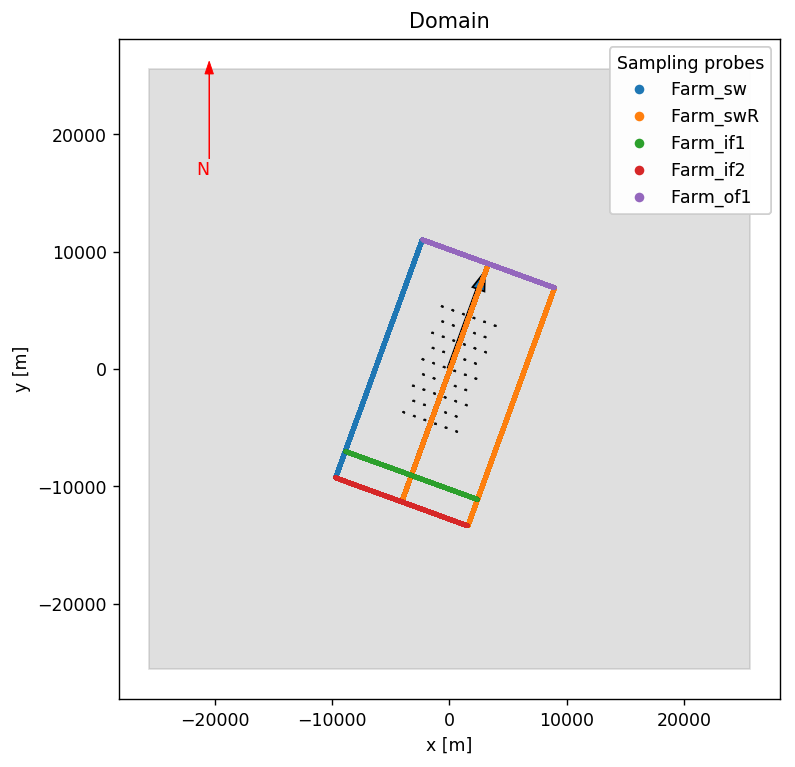

In [31]:
# Plot the domain
fig, ax = plt.subplots(figsize=(7,7), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = ['Farm_sw', 'Farm_swR','Farm_if1', 'Farm_if2', 'Farm_of1']
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY' 
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] #case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.plotDomain(ax=ax)

## Print out input files

In [32]:
# Estimate mesh size
case.estimateMeshSize()

Refinement box40: level 1: 75645000 cells
Refinement box20: level 2: 453870000 cells
Refinement box10: level 3: 2662704000 cells
Refinement T00_level_3_zone: level 4: 725760 cells
Refinement T01_level_3_zone: level 4: 725760 cells
Refinement T02_level_3_zone: level 4: 725760 cells
Refinement T03_level_3_zone: level 4: 725760 cells
Refinement T04_level_3_zone: level 4: 725760 cells
Refinement T05_level_3_zone: level 4: 725760 cells
Refinement T06_level_3_zone: level 4: 725760 cells
Refinement T07_level_3_zone: level 4: 725760 cells
Refinement T08_level_3_zone: level 4: 725760 cells
Refinement T09_level_3_zone: level 4: 725760 cells
Refinement T10_level_3_zone: level 4: 725760 cells
Refinement T11_level_3_zone: level 4: 725760 cells
Refinement T12_level_3_zone: level 4: 725760 cells
Refinement T13_level_3_zone: level 4: 725760 cells
Refinement T14_level_3_zone: level 4: 725760 cells
Refinement T15_level_3_zone: level 4: 725760 cells
Refinement T16_level_3_zone: level 4: 725760 cells
Refi

In [33]:
print(case.writeAMRWindInput(outputfile))

# --- Simulation time control parameters ---
time.stop_time                           = 30000.0             # Max (simulated) time to evolve [s]
time.max_step                            = 120000              
time.fixed_dt                            = 0.25                # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = 2000                
incflo.physics                           = ABL Actuator        # List of physics models to include in simulation.
incflo.verbose                           = 3                   
io.check_file                            = chk                 
io.restart_file                          = chk80000            
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
incflo.diffusion_type                    = 1                   # Type of diffusion scheme used.  0 = explicit diffusion, 1 = Crank-Nicolson, 2 = fully implicit

In [34]:
# Set up the precursor inputfile 
case.setAMRWindInput('ActuatorForcing', False)
print(case.writeAMRWindInput(precursorfile))

# --- Simulation time control parameters ---
time.stop_time                           = 30000.0             # Max (simulated) time to evolve [s]
time.max_step                            = 120000              
time.fixed_dt                            = 0.25                # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = 2000                
incflo.physics                           = ABL Actuator        # List of physics models to include in simulation.
incflo.verbose                           = 3                   
io.check_file                            = chk                 
io.restart_file                          = chk80000            
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
incflo.diffusion_type                    = 1                   # Type of diffusion scheme used.  0 = explicit diffusion, 1 = Crank-Nicolson, 2 = fully implicit